# Star-planet Interaction (model)
## Sub-Alfvenic flux for both a Parker spiral magnetic field configuration and a closed dipolar field configuration

In [1]:
import numpy as np
import pandas as pd
import os
import shutil

%matplotlib inline
import matplotlib
matplotlib.rc_file_defaults()


import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use(['bmh','/home/torres/Dropbox/python/styles/paper.mplstyle'])

In [2]:
### Getting the parameters to predict the SPI radio emission
#
# Observing params: Observin frequency, assumed rms noise, Delta_nu
# Stellar params: T_corona, n_base_corona, B_field, Isothermality of plasma
# Geometry of the sub-Alfvénic interaction: alpha, theta_M
#
from SPIworkflow.__init__ import *

In [3]:
# Import useful constants to be used in the code
from SPIworkflow.constants import *

In [4]:
# FUNCTION DEFINITIONS for plotting purposes
def getImage(path):
    return OffsetImage(plt.imread(path, format="jpg"), zoom=.02)

In [5]:
### FUNCTION DEFINITIONS

def Kepler_r(M_star, P_orb):
    """Computes the orbital radius of a planet (=semimajor axis)
       orbiting a star of mass M_star (in solar masses) and orbital period, P_orb (in days)
    """
    r_orb = (G * M_star)**(1/3) * (P_orb/2/np.pi)**(2/3)
    return r_orb

def beta_keV(E_kin=511):
    """ Computes the velocity of an electron with kinetic energy E_k, in units of the speed of light
        OUTPUT: beta (= particle speed / speed of light)
        INPUT: E_kin - kinetic energy of the particle, in keV
    """ 
    E_0 = 511.0 # Rest mass of the electron, in keV
    beta = np.sqrt(1 - (1 + E_kin/E_0)**(-2)) 
    return beta

def bfield_Sano(v_orb=1.0, r_orb=1.0, M_planet=M_earth, rho_core=1.0):
    """ Computes the surface magnetic field strength of a planet using the Sano scaling law.
        OUTPUT: B_planet 
        INPUT : v_orb, M_planet, R_planet
    """
    Omega_earth = 2*np.pi / 86400.  # Angular speed of Earth, in [s^(-1)] = 2*pi radians/day
    Omega_planet = v_orb / r_orb  # Angular speed of planet, in [s^(-1)] assuming it is tidally locked
    rho_core_earth = 1.0 #normalized to value of Earth
    magnetic_moment_earth = 1.05e23 # in Amperes * m^(-2)
    # core radius. The numerical value of 3.5e6 is in meters, and taken from Sano 1993
    r_core_earth = 3.486e6 #Earth outer core radius, in [meters]
    
    r_core = r_core_earth * (M_planet/M_earth)**0.44 # Scaling law from Curtis & NEss (1986)
    scaling_law = ( rho_core/rho_core_earth )**(1/2) * ( r_core/r_core_earth )**(7/2) * ( Omega_planet/Omega_earth )
    magnetic_moment_planet = magnetic_moment_earth * scaling_law
        
    #B_planet - The factor of 2 is added to yield the approx. surface magnetic field of Earth at the pole (0.5 Gauss)  
    B_planet  = 2 * magnetic_moment_planet / r_core**3 # in Tesla.  
    B_planet *= 1e-4 # In Gauss
 
    return B_planet

def Rp_eff_func(Rp, theta_M, Bp, B_tot):
    "Returns effective planet radius, in cm"
    if (Bp > 0.0):
        Rp_eff = Rp * np.sqrt(3*np.cos(theta_M/2)) * (Bp/B_tot)**(1./3.)
        Rp_eff[Rp_eff<Rp]=Rp # Rp_eff cannot be smaller than Rplanet
    else:
        Rp_eff = Rp
    
    return Rp_eff

In [6]:
def Lrad_leto(B_star=1.0, R_star=1.0, P_rot=1.0):
    """Returns the radio luminosity of an early-type magnetic star, 
    using the scaling law of Leto et al. (2021, MNRAS)
    OUTPUT: Lnu_rad, in erg/s/Hz
    INPUT: B_star, in Gauss
           R_star, in R_sun
           P_rot , in days
    """
    alpha = 13.6; beta = 1.94
    nu_ecm = B_star * 2.8e6 # in Hz
    Lnu_rad = 10**alpha * (B_star/1e3)**beta * R_star**(2*beta) * P_rot**(-beta) # erg/s/Hz
    Ltot_rad = Lnu_rad * nu_ecm
    return Ltot_rad
    

#  Next two cells to be implemented in the future
## Instead of using particle density, we'll use M_dot 
### Currently, those two cells are not used for the calculations

In [7]:
def n_wind(M_star_dot=3e-14, d=7e10, v_sw=25.6e5):
    """ Computes the particle density of the stellar wind at some distance d from the
        center of the star.
        OUTPUT: n_sw - particle density of the stellar wind at distance d, in #/cm^3
        INPUT:  M_star_dot - stellar mass-loss rate, in M_sun/yr
                d          - distance from the center of the star, in cm
                v_sw       - Speed of stellar wind at distance d, in cm/s
    """
    M_star_dot *= M_sun/yr2sec  # mass-loss rate, in grams/sec
    m_av  =  1.92e-24 # average particle mass of the solar wind, in grams
    rho = M_star_dot/(4*np.pi * d**2 * v_sw*1e5) # Density of the stellar wind, in gr/cm3
    n_sw = rho / m_av
    return n_sw

In [8]:
M_sun_dot = 2e-14 # Mass-loss rate of Sun, in M_sol/yr
# Proxima Cen
M_star_dot = 0.035*M_sun_dot
n_w = n_wind(M_star_dot, d=0.145*R_sun, v_sw=18.1)
print("Particle density is n_sw = {0:.2e} #/cm^3".format(n_w))

Particle density is n_sw = 9.92e+06 #/cm^3


In [9]:
df = pd.read_csv("./INPUT/SPI-sources_planets_MASTER.csv")
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'planet_name', 'star_name', 'p_rot(days)',
       'v sin i', 'source_p_rot', 'radius_planet(r_jup)',
       'radius_planet(r_earth)', 'Unnamed: 8', 'source_radius',
       'mass_planet(m_jup)', 'mass_planet(m_earth)', 'Unnamed: 12',
       'source_mass', 'karm_id', 'ra(hms)', 'dec(dms)', 'ra(deg)', 'dec(deg)',
       'd_star(pc)', 'radius_star(r_sun)', 'mass_star(m_sun)',
       'bfield_star(gauss)', 'bfield_err(gauss)', 'p_orb(days)',
       'source_p_orb', 'a(au)', 'source_a', 'SP_TYPE', 'gal_l', 'gal_b'],
      dtype='object')

In [10]:
df = pd.read_csv("./INPUT/SPI-table.csv")
df2 = df[["star_name", "ra(hms)", "dec(dms)", "d_star(pc)", "mass_star(m_sun)", "radius_star(r_sun)", 
          "p_rot(days)", "bfield_star(gauss)", "bfield_err(gauss)","ra(deg)", "dec(deg)"]]
mask_d = df2['d_star(pc)'] < 20.0
mask_Prot = df2['p_rot(days)'] > 0.0
mask_Bfield = df2['bfield_star(gauss)'] > 1000.0
mask_dec    = df2['dec(deg)'] > -30.0
data = df2[mask_d & mask_Prot & mask_Bfield & mask_dec]
data.reset_index(inplace=True)
len(data[:])
data[:]

TypeError: '>' not supported between instances of 'str' and 'float'

In [11]:
df = pd.read_csv("./INPUT/SPI-sources_planets_completed_no_NaN_sp_type.csv")
df = pd.read_csv("./INPUT/SPI-sources_planets_MASTER.csv")

In [12]:
df = pd.read_csv("./INPUT/SPI-sources_planets_completed_no_NaN.csv")
df2 = df[["star_name", "planet_name", "p_orb(days)", "p_rot(days)", "bfield_star(gauss)", "bfield_err(gauss)",
          "ra(hms)", "dec(dms)", "a(au)", "radius_planet(r_earth)", "mass_planet(m_earth)",
          "d_star(pc)", "mass_star(m_sun)", "radius_star(r_sun)", "ra(deg)", "dec(deg)"]]


In [13]:
df = pd.read_csv("./INPUT/SPI-sources_planets_completed_no_NaN.csv")
df = pd.read_csv("./INPUT/my-SPI-sources.csv")
data = df[["star_name", "planet_name", "p_orb(days)", "p_rot(days)", "bfield_star(gauss)",
           "a(au)", "radius_planet(r_earth)", "mass_planet(m_earth)",
          "d_star(pc)", "mass_star(m_sun)", "radius_star(r_sun)"]]
#df2['freq_cycl(ghz)'] = df2.loc[:,('bfield_star(gauss)')]*2.8e-3
# Create new column
data['freq_cycl(ghz)'] = data['bfield_star(gauss)']*2.8e-3

#data = df2[mask_d & mask_Prot & mask_Porb & mask_a & mask_Bfield & mask_dec]
#data = data.drop_duplicates(subset=['star_name'])
data.reset_index(inplace=True)
data[:]

<ipython-input-13-5f4b73eb02dc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['freq_cycl(ghz)'] = data['bfield_star(gauss)']*2.8e-3


,index,star_name,planet_name,p_orb(days),p_rot(days),bfield_star(gauss),a(au),radius_planet(r_earth),mass_planet(m_earth),d_star(pc),mass_star(m_sun),radius_star(r_sun),freq_cycl(ghz)
0,0,Proxima,Proxima b,11.18600,82.530,600.0,0.048500,1.100,1.27,1.300000,0.1230,0.1450,1.6800
1,1,Proxima,Proxima d,5.12000,82.530,600.0,0.029000,0.500,0.26,1.300000,0.1230,0.1450,1.6800
2,2,GJ 1151,GJ1151 b,1.00000,125.000,50.0,0.011000,1.000,NaN,8.040000,0.1900,0.2100,0.1400
3,3,GJ 1151,GJ1151 b,2.00000,125.000,50.0,0.017000,1.000,NaN,8.040000,0.1900,0.2100,0.1400
4,4,AU Mic,AU Mic b,8.46321,4.860,500.0,0.066000,4.070,NaN,9.790000,0.5000,0.7500,1.4000
5,5,GJ 393,GJ393 b,7.00000,34.100,NaN,0.054000,1.300,NaN,7.000000,0.4300,0.4500,NaN
6,6,GJ 486,GJ486 b,1.46700,130.000,NaN,0.017000,1.306,NaN,8.100000,0.3230,0.3280,NaN
7,7,GJ 740,GJ740 b,2.37756,35.563,NaN,0.029000,1.430,NaN,11.101700,0.5600,0.5600,NaN
8,8,G 264-12,G264-12 b,2.31000,100.000,NaN,0.023000,1.300,NaN,16.000000,0.2970,0.3050,NaN
9,9,TOI-4559,TOI-4559 b,2.77000,38.000,180.0,0.029000,1.220,2.6,10.000000,0.4390,0.4390,0.5040


In [14]:
#print(df[' Period'][indi])
#print(data.to_latex(index=False, columns=['planet_name', 'ra(hms)', 'dec(dms)', 'd_star(pc)', 
#                                          'p_rot(days)', 'bfield_star(gauss)', 'radius_planet(r_earth)',   
#                                          'p_orb(days)', 'freq_cycl(ghz)']))
#      
#["planet_name", "p_orb(days)", "p_rot(days)", "bfield_star(gauss)", "bfield_err(gauss)",
#          "ra(hms)", "dec(dms)", "a(au)", "radius_planet(r_earth)", "mass_planet(m_earth)",
#          "star_name", "d_star(pc)", "mass_star(m_sun)", "radius_star(r_sun)", "ra(deg)", "dec(deg)"]]

In [15]:
# Sound speed, in cm/s- Depends only on the Temperature of the stellar corona
vsound = np.sqrt(5/3 * k_B * T_corona/m_h) 

# average particle mass in the stellar wind (we take a Sun-like value), in g * cm^(-3)
m_average = 1.92e-24 

In [16]:
# If OUTPUT directory does not exist, then create it.
outdir = 'OUTPUT'
try:
    os.mkdir(outdir)
    print('Directory', outdir, 'created')
except FileExistsError:
    print('Directory', outdir, 'already exists')

Directory OUTPUT already exists


In [17]:
#indi = 1

#for indi in range(len(data)):
indis = [10]
for indi in indis:
    planet = data['planet_name'][indi]
    #print("Planet = {0:12s}\n".format(planet))
    d      = data['d_star(pc)'][indi] * pc               # Distance to stellar system , in  cm
    B_star = data['bfield_star(gauss)'][indi]            # Stellar surface magnetic field
    M_star = data['mass_star(m_sun)'][indi] * M_sun
    P_orb  = data['p_orb(days)'][indi] # Orbital period, in days
    Exoplanet = data['planet_name'][indi]
    Rp = data['radius_planet(r_earth)'][indi]*R_earth # Planetary radius
    Mp = float(data['mass_planet(m_earth)'][indi])*M_earth # Planetary mass
    r_orb  = data['a(au)'][indi]*au    # orbital distance, in cm
    nu_ecm = data['freq_cycl(ghz)'] # in GHz
    #P_orb  *= 86400 # Orbital period, in cgs
    #semimajor_a = Kepler_r(M_star, P_orb)/au
    R_star = data['radius_star(r_sun)'][indi]
    #orb_distance = data['a(au)'][indi]*au / (R_star*R_sun) # in stellar radii
    P_rot_star = float(data['p_rot(days)'][indi])   # Rotation period  of star, in days
    #print(type(P_rot_star), type(M_star))
    #P_rot_star *= day    # Rotation period  of star, in sec
    Ltot_rad = Lrad_leto(B_star, R_star, P_rot_star) # in erg/s
    #Lnu_rad  = Ltot_rad / (nu_ecm*1e9)
    #Flux_nu_rad = Lnu_rad/(4*np.pi *  d**2)  
    #print("Ltot_rad = {0:2.1e} erg/s".format(Ltot_rad))
    print("Rp = {0:2.1e} R_earth; Mp = {1:2.1e} M_earth".format(Rp/R_earth, Mp/M_earth))
    print("Done with planet {0:12s}\n.".format(planet))

Rp = 1.6e+00 R_earth; Mp = 3.6e+00 M_earth
Done with planet TOI-4559 c  
.


In [18]:
# Quitar en el futuro?
def B_shulyak(P_rot):
    """Computes the magnetic field of the star, in Gauss, for an assumed P_rot, in days.
    Based on a fit to the data in Shulyak+2019 (Nature Ast), carried out by LPM.
    The values do not make sense. Ask LPM to check the fitted values
    """
    m = -0.29649; n =  3.54299
    B = int(10**(m * np.log10(P_rot/day) + n)) 
    return B

287
Done with planet Proxima b


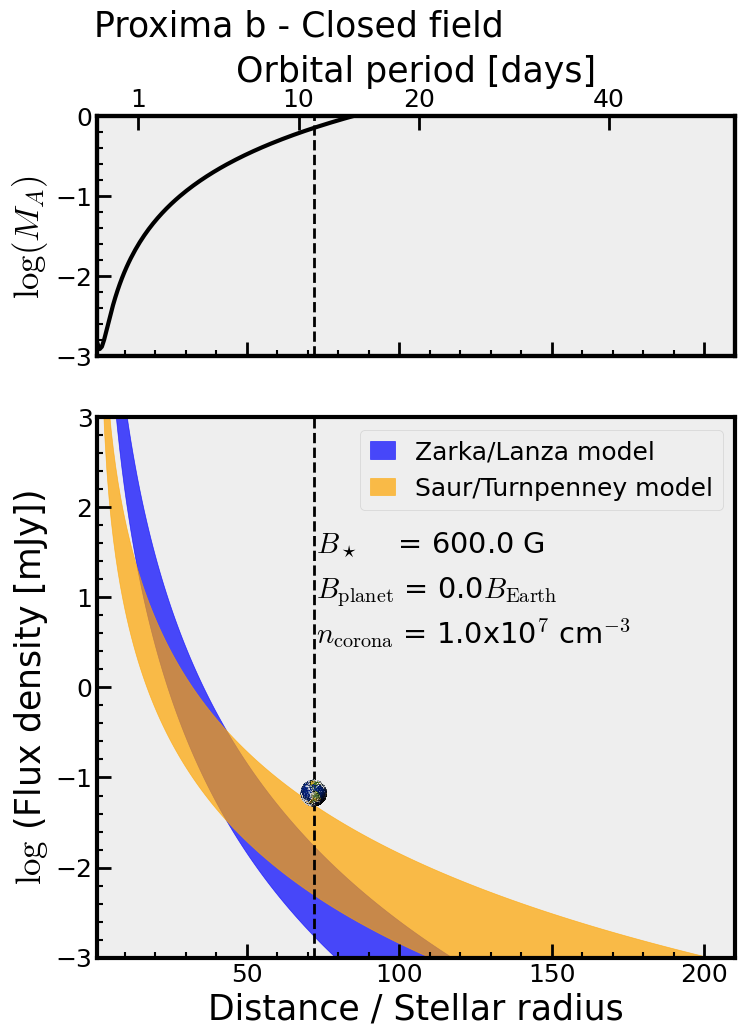

In [21]:
# Setting the stellar magnetic field geometry and the value of the 
# intensity of the planetary magnetic field
# 

# Stellar magnetic field geometry
# The convention is that Bfield_geom_arr = 1 => open Parker spiral geometry; 
#  Bfield_geom_arr = 0 - closed dipolar geometry

# Magnetic field of the planet
#  Bp0_arr = 0 - unmagnetized planet, i.e., B_planet = 0 G; 
#  Bp0_arr = 1 - magnetized planet, i.e., B_planet = 0 G; 

Bfield_geom_arr = [0]
Bp0_arr= [0]
#Bfield_geom_arr = [0,1]
#Bp0_arr= [0,1]

#for indi in range(len(data)):
#star_array = [92, 93, 94, 95]
#star_array = range(len(data))
star_array = [0]
for indi in star_array:
    #indi=63
    d      = data['d_star(pc)'][indi] * pc               # Distance to stellar system , in  cm
    R_star = data['radius_star(r_sun)'][indi] * R_sun    # Stellar radius in cm
    M_star = data['mass_star(m_sun)'][indi] * M_sun      # Stellar mass in g,
    P_rot_star = float(data['p_rot(days)'][indi]) * day  # Rotation period  of star, in sec
    B_star = data['bfield_star(gauss)'][indi]            # Stellar surface magnetic field
  
    # Planet - 
    Exoplanet = data['planet_name'][indi]
    Rp = data['radius_planet(r_earth)'][indi]*R_earth # Planetary radius
    Mp = float(data['mass_planet(m_earth)'][indi])*M_earth # Planetary mass
    r_orb  = data['a(au)'][indi]*au    # orbital distance, in cm
    P_orb = data['p_orb(days)'][indi] #orbital period of planet, in days
    
    
    for ind in Bfield_geom_arr:
        for ind1 in Bp0_arr:

            # Common properties for star and planet
            # 
            Omega_star = 2.0*np.pi / P_rot_star # Angular rotation velocity of the star
            M_star_msun = M_star / M_sun # Stellar mass in units of solar mass
        
            r_sonic =  G * M_star / (2 * vsound**2) # Radius of sonic point

            # MPT: The two lines below ("Nsteps" and "d_orb" should be outside this loop, 
            # but for some reason to be understood, the first time results in v_sw[0] = 0, which in turn results
            # in a division by zero. This causes exiting the program. So, for now, we keep those lines inside the loop, which 
            # prevents the zeroth value. Maybe the line v_sw = np.zeros(len(d_orb)) is causing the trouble? Check it
            #Nsteps = 10
            d_orb_max = 2*r_orb/R_star # Max. orbital distance, in units of R_star
            Nsteps = int(2*d_orb_max)
            #d_orb = np.linspace(1.002, 10, Nsteps) * R_star # Array of (orbital) distances to the star
            #d_orb = np.linspace(2.00, d_orb_max, Nsteps) * R_star # Array of (orbital) distances to the star
            d_orb = np.linspace(1.02, 210, Nsteps) * R_star # Array of (orbital) distances to the star
            print(len(d_orb))
            v_orb = (G * M_star/d_orb)**0.5 # Orbital speed of planet as f(distance to star), in cm/s
            v_corot = d_orb * Omega_star # Corotation speed (cm/s)

            #
            # The wind speed is computed as in Turnpenney+18
            #
            # using the Lambert W function
            # D_r as in Eq. 18 of Turnpenney+2018, which is taken from eq. 15 in Cranmer 2004

            from scipy.special import lambertw
            D_r = (d_orb/r_sonic)**(-4) * np.exp(4*(1 - r_sonic/d_orb) - 1)
            v_sw2 = np.zeros(len(d_orb), dtype=complex)
            v_sw  = np.zeros(len(d_orb))

            for i in range(len(d_orb)):
                if (d_orb[i]/r_sonic) >= 1.0:
                    v_sw2[i] = -vsound**2 * lambertw(-D_r[i], k=-1)
                else: 
                    v_sw2[i] = -vsound**2 * lambertw(-D_r[i], k=0)
                # The actual speeed is the real part of v_sw2[i]
                v_sw[i]  = np.sqrt(v_sw2[i].real)

            v_sw_base = v_sw[0]    # Stellar wind velocity at the closest distance to the star
            
            #print("V_sound = {0:.3f} km/s; V_sw at the base = {1:.3f} km/s".format(vsound/1e5, v_sw_base/1e5))    
            
            # Eq. 23 of Turnpenney+18 - Second term of RHS 
            # The vector v_rel = v_sw - v_orb (Eq. 5 in Saur+13, and see also Fig. 1 in Turnpenney+18)
            # 
            v_rel = np.sqrt(v_orb**2 + v_sw**2) # Relative speed between stellar wind and obstacle
            v_rel_angle = np.arctan(v_orb/v_sw) # Angle between radial vector and relative velocity
            
            # n_dplanet - Number density at orbital distance to the planet. 
            # If the stellar plasma is assumed to be isothermal, then 
            # the density falls down as ~ R^(-2) * v_sw^(-1).
            #
            # Alternatively, we fix the density at the distance of the planet from the host star.
            #
            if isothermal:
                n_dplanet = n_sw_base * (d_orb/R_star)**(-2) / (v_sw/v_sw_base) # Plasma density at distance (R/R_star)
            else:
                n_dplanet = 1e4  # fixed                 
                
            # Magnetic field geometry
            # open_field - defines the geometry of the magnetic field
            open_field = Bfield_geom_arr[ind]
            
            if open_field: 
                # Open Parker Spiral - Falls down with distances as R^(-2) rather than R^(-3) as in the dipole case
                B_r = B_star * (d_orb/R_star)**(-2) # Stellar wind B-field at (R/R_star), Eqn 20 Turnpenney 2018
                B_phi = B_r * v_corot/v_sw # Azimuthal field (Eqn 21 Turnpenney 2018)
                B_tot = np.sqrt(B_r**2 + B_phi**2) # Total B-field at planet orbital distance

                # Eq. 23 of Turnpenney 2018 -  First term of RHS
                B_ang = np.arctan(B_phi/B_r) # Angle the B-field makes with the radial direction

                # Angle between the stellar wind magnetic field and the impinging plasma velocity
                theta = np.absolute(B_ang - v_rel_angle) # Eqn 23 in Turnpenney 2018

                # theta is the angle between the B_sw (the insterstellar magnetic field), and the
                # incident stellar wind velocity.  See Fig. 1 in Turnpenney+2018
                #
                geom_f = (np.sin(theta))**2 # Geometric factor in efficiency 
            else:
                # Closed, dipolar configuration - It falls with distance as R^(-3)
                # B_star - magnetic field at the magnetic equator on the stellar surface
                # 
                phi = 0. # azimuth, measured from the North magnetic pole of the star (in degrees)
                phi *= np.pi/180. # to radians

                B_r   = -2 * B_star * (d_orb/R_star)**(-3) * np.cos(phi) # Radial component of the dipole magnetic field of the stellar wind as f(distance to star)
                B_phi = - B_star * (d_orb/R_star)**(-3) * np.sin(phi) # Azimuthal component of the dipole magnetic field 
                B_tot = np.sqrt(B_r**2 + B_phi**2) # Total dipole magnetic field 

                geom_f = 1.0 # Geometric factor. 1 for closed dipole configuration, different for the open field configuration

            # Alfven speed and Mach Number
            rho_sw = m_average * n_dplanet #density, in g * cm^(-3)
            #v_alf = 2.18e11 * B_tot / np.sqrt(n_dplanet) # Alfven speed at the distance of the planet, in cm/s
            #v_alf = B_tot / np.sqrt(4.0 * np.pi * rho_sw) 
            # Relativistically corrected Alfvén speed, as v_alf must be less than the speed of light
            v_alf = B_tot / np.sqrt(4.0 * np.pi * rho_sw) * 1./np.sqrt(1 + (B_tot**2/(4.*np.pi * rho_sw * c**2)))
            M_A   = v_rel/v_alf # Alfven mach number
            
            #Radial Alfvén speed
            mu_0_cgs = 1.0 # magnetic permeability in vacuum, in cgs units
            
            v_alf_r = B_r / np.sqrt(mu_0_cgs * rho_sw) # in cm/s
            M_A_radial = np.abs(v_sw / v_alf_r)



            #print('Relative speed = {0:.1e} km/s \n', format(v_rel/1e5))
            #print('Alfvén speed   = {0:.1e} km/s \n', format(v_alf/1e5))
            #print('Alfvén Mach number = {0:.3f} \n', format(M_A))
            #print('v_alf_rel/v_alf  = {0:.1e} km/s \n', format(v_alf_rel/v_alf))

            #print('Wind speed   = {0:.1e} km/s \n', format(v_sw/1e5))
            #print('Alfvén radial speed = {0:.1e} km/s \n', format(v_alf_r/1e5))
            #print('Alfvén radial Mach number = {0:.3f} \n', format(M_A_radial))

            # defines whether planet is unmagnetized (Bp0=0), or magnetized (Bp0 = 1)
            Bp0 = Bp0_arr[ind1]
            
            if Bp0:
                Bp = bfield_Sano(v_orb, d_orb, Mp) # Sano (1993) scaling law
                #Bp = np.ones(len(d_orb))
            else:
                Bp = np.zeros(len(d_orb)) # unmagnetized planet
            
            # Planetary magnetic field (as a function of orbital distance)
            #
            # This is a simple Sano(1993) scaling law dependence, assuming a tidally locked planet, 
            # core_radius equal to the Earth radius, and core density equal to that of the Earth.
            # 
            #
            # Bp0 is the magnetic field at the assumed orbital distance
            #    
            #Bplanet_dep = 0
            #if Bplanet_dep:
            #    Bp = Bp0 * M_star_msun**(1/2)/(d_orb/au)**(3/2) * (P_orb/yr)
            #else:    
            #    Bp = Bp0  #If we don't use any dependence, then Bp = Bp0
            
            #print('Bp = ', Bp)
            #
            # Effective radius of the Alfvén wing, in units of R_p (R_obst in Eq. 57 of Saur+2013, A&A)
            # It depends on the orientation, theta_M, of the intrinsic planetary magnetic field (Bp) 
            # wrt the external magnetic field (B_tot).
            #
            
            #if (Bp > 0.0):
            #    Rp_eff = Rp * np.sqrt(3*np.cos(theta_M/2)) * (Bp/B_tot)**(1./3.)
            #    Rp_eff[Rp_eff<Rp]=Rp # Rp_eff cannot be smaller than Rplanet
            #else:
            #    Rp_eff = Rp  
            Rp_eff = Rp * np.sqrt(3*np.cos(theta_M/2)) * (Bp/B_tot)**(1./3.)
            Rp_eff[ Rp_eff < Rp] = Rp # Rp_eff cannot be smaller than Rplanet    
            #print("Planetary Magnetic field = {0:.1f} G".format(Bp))
            #print("The effective radius is {0:.1e}".format(Rp_eff))
            #print(f"Rp_eff = \n {Rp_eff}")
            #print(f"Rp_eff/Rp = \n {Rp_eff/Rp}")
            # 
            # Total Poynting flux, as in Saur+2013 - Eq. 55 (page 7 of 20)
            # Applies if  M_A is small (<< 1)
            # Note that for the geometric factor, we follow Turnpenney's definition, so 
            # the factor is sin^2(theta), not cos^2(theta)
            #
            # Total Poynting flux (S_mks), in mks units [kg * m * s^(-2) * A^(-2)]
            mu_0 = 4*np.pi*1e-7 # magnetic permeability in vacuum, in mks units
            S_poynt_mks = 2*np.pi*(Rp_eff/1e2)**2 * (alpha*M_A)**2 *(v_alf/1e2) \
                  * (B_tot/1e4)**2/mu_0 * geom_f
            S_poynt = S_poynt_mks * 1e7 # Total Poynting flux, in cgs units (erg/s) 
            
            
            # Total Poynting flux, as in Lanza 2009 (Eq. 8) and Zarka 2007 (Eq. 9) 
            # They have a value which is different by a factor 2 * M_A * alpha^2
            # In addition, they include a geometric factor of order 1/2.
            #
            ZL_factor = 0.5
            S_poynt_ZL = S_poynt * ZL_factor / (2 * M_A * alpha**2 * geom_f)
            
            # Beam solid angle covered by the ECM emission
            # It depends on the kinetic energy of electrons (as beta is determined from them), in keV
            #
            #Ekin_min = 10 ; Ekin_max = 511        
            Ekin_min = 20 ; Ekin_max = 200
            beta_min = beta_keV(Ekin_min); beta_max = beta_keV(Ekin_max)
            
            # BEAM SOLID ANGLE
            # We assume an emission cone with half-opening angle theta and angular width d_theta.
            # theta and d_theta are related to the speed of the electrons as theta \approx d_theta \approx v/c = beta
            # 
            # The solid angle, Omega, of a cone with half-opening angle, theta, 
            # is Omega = 2*np.pi * (1. - np.cos(theta))
            # Therefore, a cone sheet with inner half-opening angle, theta, and angular width d_theta
            # has a solid angle Omega = 2*np.pi* ( np.cos (theta - d_theta/2) - np.cos(theta +d_theta/2)) 
            
            #Range of beam solid angles (Omega) for the emitter depends on beta_min and beta_max
            Omega_1 = 2*np.pi * (np.cos(np.arccos(beta_min) - beta_min/2) - np.cos(np.arccos(beta_min) + beta_min/2)) 
            Omega_2 = 2*np.pi * (np.cos(np.arccos(beta_max) - beta_max/2) - np.cos(np.arccos(beta_max) + beta_max/2)) 
            
            # beam solid angle of the emitter / 4*pi 
            # Check why I (MPT) wrote " /4*pi" in the previous line 
            Omega_min = min(Omega_1, Omega_2)
            Omega_max = max(Omega_1, Omega_2)

            
            #print("beta_min of electrons (E_k={0:.1f} keV) = {1:.3f}; \n beta_max of electrons (E_k={2:.1f} keV) = {3:.3f}".\
            #      format(Ekin_min, beta_min, Ekin_max, beta_max))
            #print("Half-opening angle of emission cone: theta_min = {0:.1f} deg; theta_max = {1:.1f} deg".\
            #       format(np.arccos(beta_max)*180./np.pi, np.arccos(beta_min)*180/np.pi))
            #print("(Angular) width of emission cone: theta_min = {0:.1f} deg; theta_max = {1:.1f} deg".\
            #       format(beta_min*180./np.pi, beta_max*180/np.pi))
            #print("solid angles: Min = {0:.3f}; Max = {1:.3f}".format(Omega_min, Omega_max))
            #print(" ")

            # in-band radio power received from one whole hemisphere
            #power  = 2*np.pi * flux * mJy * d**2 * Delta_nu_obs 

            # The range of allowed powers, considering the beamed solid angle
            # and the possible total bandwidth
            # 
            gyrofreq = e*B_star/(2*np.pi * m_e * c)
            Delta_nu_cycl = 0.5 * gyrofreq # width of ECMI emission = (0.5 * gyrofreq)
        
            #Fix flux_min = flux_max = flux
            #flux_min = flux_max = flux 

            #
            #power_min = power/(2*np.pi) * (flux_min/flux) * Omega_min * Delta_nu_cycl/Delta_nu_obs
            #power_max = power/(2*np.pi) * (flux_max/flux) * Omega_max * Delta_nu_cycl/Delta_nu_obs
            #
            # Range of values for the star-ward Poynting flux
            #Poynt_min = power_min / eps_max 
            #Poynt_max = power_max / eps_min 

            #print("In-band power (from 1 whole hemisphere) =  {0:.2e}".format(power))
            #print("power (from 1 sr)  =  {0:.2e}".format(power/2/np.pi * Delta_nu_cycl/Delta_nu_obs))
            #print("power_min =  {0:.2e}; power_max = {1:.2e}".format(power_min, power_max))
            #print("Poynting fluxes: Min = {0:.2e}; Max = {1:.2e}".format(Poynt_min, Poynt_max))
            # Flux density received at Earth (from the theoretically expected Poynting flux)
            # 
            
            #beam solid angle of the ECMI emission, in sterradians. There is no need to fix this value, as this is
            #given by the population of electrons. If we don't fix it, we can constrain other parameters, e.g., 
            # eps, the efficienty factor in converting energy into Poynting flux.
            Omega = 1.6 

            # For simplicity, take Omega_min = Omega_max = Omega
            Omega_min = Omega_max = Omega
            
            dilution_factor_min = eps_min / (Omega_max * d**2 * Delta_nu_cycl) 
            dilution_factor_max = eps_max / (Omega_min * d**2 * Delta_nu_cycl)

            # Min and Max expected flux density to be received for Saur-Turnpenney model, in erg/s/Hz/cm2
            Flux_r_S_min = S_poynt * dilution_factor_min
            Flux_r_S_min *= 1e26 # Flux density, in mJy
            Flux_r_S_max = S_poynt * dilution_factor_max
            Flux_r_S_max *= 1e26 # Flux density, in mJy

            # Min and Max expècted flux density to be received for Zarka-Lanza model, in erg/s/Hz/cm2
            Flux_r_S_ZL_min = S_poynt_ZL * dilution_factor_min
            Flux_r_S_ZL_min *= 1e26 # Flux density, in mJy
            Flux_r_S_ZL_max = S_poynt_ZL * dilution_factor_max
            Flux_r_S_ZL_max *= 1e26 # Flux density, in mJy
            

            ###########################################################################
            ####                  PLOTTING                                         ####
            ###########################################################################
            
            ### Plot received flux density as a function of distance from the star
            ###
            #matplotlib.rc_file_defaults()
            #plt.style.use(['bmh', '/home/torres/Dropbox/python/styles/paper.mplstyle'])

            lw = 3

            # Kepler's third law, with d_orb_mark in units of R_star, 
            # so that period_mark is in days.
            #
            period_mark = np.array([1, 10, 20, 40, 80, 100, 120, 140, 160,])
            d_orb_mark = (period_mark/yr)**(2/3) * M_star_msun**(1/3) * (au/R_star)

            # Plot only Flux density vs. orbital distance, or also log(M_A) vs. d_orb 
            multiple = 1
            if multiple:
                plt.figure(figsize=(8,11))
                ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1)
                ax2 = plt.subplot2grid((3,1),(1,0),rowspan=2,colspan=1)
            else:
                plt.figure(figsize=(8,7.5))
                ax2 = plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1)


            x   = d_orb/R_star # (distance array, in units of R_star)

            y_min = np.log10(Flux_r_S_min) # minimum flux (array), Saur/Turnpenney model
            y_max = np.log10(Flux_r_S_max) # maximum flux (array)
            y_min_ZL = np.log10(Flux_r_S_ZL_min) # minimum flux (array), Zarka/Lanza model
            y_max_ZL = np.log10(Flux_r_S_ZL_max) # maximum flux (array)

            #
            #ax1.plot(x, np.log10(M_A), lw=lw)
            ax1.plot(x, np.log10(M_A), color='k', lw=lw)
            #ax2.plot(x, y_min, lw=lw, color='orange', lw=lw, label="Saur/Turnpenney model")
            #ax2.plot(x, y_max, lw=lw, color='orange')
            
            # Fill with color for ZL and ST models
            #
            ax2.fill_between(x, y_min_ZL, y_max_ZL, color="blue", alpha=0.7, label="Zarka/Lanza model")
            ax2.fill_between(x, y_min, y_max,color="orange", alpha=0.7, label="Saur/Turnpenney model")


            #ax2.plot(dvec/R_star,np.log10(Flux_r_S), lw=lw, label="Saur/Turnpenney model")
            #ax2.plot(dvec/R_star,np.log10(Flux_r_S_ZL), lw=lw,label = "Zarka/Lanza model")
            #
            #ax2.fill_between([np.amin(dvec)/R_star,np.amax(dvec)/R_star], \
            #                 [np.log10(Poynt_min),np.log10(Poynt_min)], \
            #                 [np.log10(Poynt_max),np.log10(Poynt_max)],color="orange",alpha=0.4)

            ax11 = ax1.twiny()
            ax11.set_xticks(d_orb_mark)
            ax11.set_xticklabels(period_mark)
            ax11.tick_params(top=False,which='minor')
            ax1.tick_params(top=False,which='both')
            ax1.set_xticklabels([])
            #ax2.tick_params(labeltop=False, labelright=True)

            xmin = np.amin(d_orb)/R_star
            xmax = np.amax(d_orb)/R_star
            
            # Axis limits
            ax11.set_xlim([xmin, xmax])
            ax1.set_xlim([xmin, xmax])
            ax2.set_xlim([xmin, xmax])

            #ax11.set_xlim(5,50)
            #ax1.set_xlim(5,50)
            #ax2.set_xlim(5,50)

            #ax1.set_xscale('log')
            #ax2.set_xscale('log')
            #VALORES ORIGINALES
            ax1.set_ylim([-3,0])
            ax2.set_ylim([-3,3])
            #VALORES TEST
            #ax1.set_ylim([-50,20])
            #ax2.set_ylim([-50,80])

            # Draw vertical line at average position of Gl 514b
            ax1.axvline(x=r_orb/R_star, ls='--', color='k', lw=2)
            ax2.axvline(x=r_orb/R_star, ls='--', color='k', lw=2)
            
            #Draw vertical line at 0.23 au
            ax1.axvline(x=0.23*au/R_star, ls='--', color='k', lw=2)
            ax2.axvline(x=0.23*au/R_star, ls='--', color='k', lw=2)
            
            
            #
            ax11.set_xlabel("Orbital period [days]")
            ax2.set_xlabel(r"Distance / Stellar radius")
            ax1.set_ylabel(r"${\rm log} (M_A)$")
            ax2.set_ylabel(r"${\rm log}$ (Flux density [mJy])")

            #Draw also Alfven radial Mach number
            draw_M_A_radial = 0
            if draw_M_A_radial:
                ax12 = ax1.twinx() #instantiate 2nd axes that shares the same x-axis
                ax12.set_ylim([-3,0])
                color = 'tab:blue'            
                ax12.set_ylabel('')
                ax12.plot(x, np.log10(M_A_radial), color=color, lw=lw)
                ax12.set_ylabel(r"${\rm log} (M_{A, \rm radial})$", color=color)
                ax12.tick_params(axis='y', labelcolor=color)
            
            # draw 3*rms upper limit
            draw_rms = 0
            if draw_rms:
                ax2.axhline(y=np.log10(3*rms), ls='-.', color='grey', lw=2)
                xpos = d_orb_max/6
                ypos = np.log10(4*rms)
                ax2.text(x=xpos,y=ypos,s=r"3$\times$RMS",fontsize='small')
            
            ax1.plot([xmin, xmax],[22,22],'k--') # This line needs to be modified to take into account different
            ax2.legend(loc=1)

            # draw a little Earth at the planet position for visualization purposes
            paths = ['./pics/earth.png']
            x = [r_orb/R_star]
            y = [np.log10(3*rms)]
            for x0, y0, path in zip(x, y, paths):
                ab_earth = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
                ax2.add_artist(ab_earth)            
    
            #Print out relevant input and output parameters, including the expected flux received at Earth 
            # from the SPI at the position of the planet
            # To this end, first find out the position of the planet in the distance array
            d_diff = np.abs((d_orb-r_orb)/R_star)
            loc_pl = np.where(d_diff == d_diff.min())

            B_pl_loc = round(float(Bp[loc_pl]/bfield_earth), 2) # Planetary magnetic field, in units of Bfield_earth
            #B_pl_loc = int(Bp[loc_pl]) # Planetary magnetic field, in Gauss
            print(f"Done with planet {Exoplanet}")
            
            #ax2.text(x=60,y=1.8,s=r"$B_\ast = \,{\rm G}$")
            #ax2.text(x=60,y=1.4,s=r"$B_{\rm pl} = 1 \,{\rm G}$")
            #
            #ax2.text(x=12,y=-1.2,s=r"$B_{\rm cycl}$   = " + str(B_star) + " G ",fontsize='small')
            #ax2.text(x=12,y=-1.6,s=r"$B_{\rm planet}$ = " + str(Bp) + " G ", fontsize='small')
            #ax2.text(x=12,y=-2.0,s=r"$n_{\rm corona}$ = " + str(n_sw_base/1e7) + "x10$^7$ cm$^{-3}$ ", fontsize='small')
            #ax2.text(x=3,y=0.1+np.log10(3*rms),s=r"Requested 3$\sigma$", fontsize='x-small')
            xpos = d_orb_max / 2 + 0.7
            ypos = 1.5
            d_ypos = 0.5
            ax2.text(x=xpos,y=ypos,s=r"$B_\star$    = " + str(B_star) + " G ",fontsize='small')
            ax2.text(x=xpos,y=ypos-d_ypos,s=r"$B_{\rm planet}$ = " + str(B_pl_loc) + r"$B_{\rm Earth}$", fontsize='small')
            ax2.text(x=xpos,y=ypos-2*d_ypos, s=r"$n_{\rm corona}$ = " + str(n_sw_base/1e7) + "x10$^7$ cm$^{-3}$ ", fontsize='small')
        
            common_string = str(B_star)+"G"+"-Bplanet"+str(Bp[loc_pl])+"G"
            if open_field:
                ax1.text(x=0, y=1, s= Exoplanet + " - Open field")
                outfile = Exoplanet + "-Open-Bstar"+ common_string
            else:
                ax1.text(x=0, y=1, s= Exoplanet + " - Closed field")
                outfile = Exoplanet + "-Closed-Bstar"+ common_string

            plt.tight_layout()
            
            # Variable to send output to files (output=1), or show them in the notebook (output = 0) 
            output = 0
            
            if output:
                common_string = str(B_star)+"G"+"-Bplanet"+str(Bp[loc_pl])+"G"
                if open_field:
                    ax1.text(x=0, y=1, s= Exoplanet + " - Open field")
                    out = Exoplanet + "-Open-Bstar"+ common_string
                else:
                    ax1.text(x=0, y=1, s= Exoplanet + " - Closed field")
                    out = Exoplanet + "-Closed-Bstar"+ common_string
                
                outfilePDF = os.path.join(outdir, outfile+".pdf")
                plt.savefig(outfilePDF)
                plt.close()
            else:
                plt.show()
            
            
            
            outfileTXT = os.path.join(outdir, outfile+'.txt')
            with open(outfileTXT, 'w') as f:
                f.write('# INPUT PARAMETERS:  ########\n') 
                #f.write('B_star = {0:.0f} G; B_planet = {1:.0f} G\n'.format(B_star, Bp[loc_pl]))
                f.write('T_corona = {0:.0e} K\n'.format(T_corona))
                f.write('Stellar wind particle density at the base = {0:.0e} cm-3\n\n'.format(n_sw_base))
                f.write('# OUTPUT PARAMETERS: ########\n')
                f.write('ECMI freq (fundamental) = {0:.0f} MHz\n'.format(gyrofreq/1e6))
                f.write('Flux_ST: ({0}, {1}) mJy\n'.format(Flux_r_S_min[loc_pl], Flux_r_S_max[loc_pl]))
                f.write('Flux_ZL: ({0}, {1}) mJy\n'.format(Flux_r_S_ZL_min[loc_pl], Flux_r_S_ZL_max[loc_pl]))
            

In [ ]:
# Print out the expected flux received at Earth from the SPI at the position of the planet

# First, find out the position of the planet in the distance array
d_diff = np.abs((d_orb-r_orb)/R_star)
location_pl = np.where(d_diff == d_diff.min())

#print('S_poynt: {0} erg/s\n'.format(S_poynt))
#print('Flux_ST: {0} mJy\n'.format(Flux_r_S_max))    
#print('Flux_ZL: {0} mJy\n'.format(Flux_r_S_ZL_max))    

# Print out minimum and maximum values of flux density at the planet location
#print("B_star =", B_star, " G; " "B_planet = ", Bp, " G ")
print("\nPrint out Poynting Flux at the planet location")
print("Saur/Turnpenney (erg/s): ", S_poynt[location_pl])
print("\nPrint out Poynting Flux at the first cell")
print("Saur/Turnpenney (erg/s): ", S_poynt[0])

print("\nPrint out minimum and maximum values of flux density at the planet location")
print("Saur/Turnpenney (mJy): ", Flux_r_S_min[location_pl], Flux_r_S_max[location_pl])
#print("Zarka/Lanza: (mJy)", Flux_r_S_ZL_min[location_pl], Flux_r_S_ZL_max[location_pl])
print("\nPrint out minimum and maximum values of flux density at the first cell")
print("Saur/Turnpenney (mJy): ", Flux_r_S_min[0], Flux_r_S_max[0])
#print("Zarka/Lanza: (mJy)", Flux_r_S_ZL_min[0], Flux_r_S_ZL_max[0])